# Mask R-CNN

In [1]:
%matplotlib inline

In [2]:
import os
import sys
import glob
import random
import math
import numpy as np
import pandas as pd
import skimage.io
import skimage.transform
from skimage.morphology import label  #Used for Run-Length-Encoding RLE to create final submission

import matplotlib
import matplotlib.pyplot as plt

from MaskRCNN.config import Config
import MaskRCNN.utils as utils
import MaskRCNN.model as modellib
import MaskRCNN.visualize as visualize
from MaskRCNN.model import log

C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save submission outputs 
OUTPUT_DIR = os.path.join(ROOT_DIR, "outputs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print("Download the COCO trained weights")
    # utils.download_trained_weights(COCO_MODEL_PATH)
    

Download the COCO trained weights


In [4]:
train_path = os.path.join(ROOT_DIR, 'input/stage1_train')
val_path = os.path.join(ROOT_DIR,'input/stage1_val')
test_path = os.path.join(ROOT_DIR, 'input/stage1_test')   #path to test data file/folder

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [5]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 6 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 6

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 for nuclei

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 320

    # Use smaller anchors because our image and objects are small
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
#     TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 200   # num_images / batch_size

    VALIDATION_STEPS = 10
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[80 80]
 [40 40]
 [20 20]
 [10 10]
 [ 5  5]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 6
IMAGE_MAX_DIM                  320
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

In [6]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
# inference_config.display()

## Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

## Image Dimensions

```
(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
```

In [8]:
def display_masks(image, mask, class_names):
    """Display the given image and the masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    
#     to_display.append(mask)
    
    # Pull masks of instances belonging to the same class.
    m = mask
    m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
    to_display.append(m)
    titles.append("H x W={}x{} - {}".format(image.shape[0], image.shape[1], class_names[0]))
    visualize.display_images(to_display, titles=titles, cols=2, cmap="Blues_r")

In [9]:
class NucleiDataset(utils.Dataset):
    """Loads the nuclei dataset.
    """
    
    def load_nuclei(self, path):
        '''
        Loads images from path/{id}/images/{id}.png
        '''
        self.add_class("nuclei", 1, "nuclei")
        self.path = path
        
        img_info = [(id, '{0}/{1}/images/{1}.png'.format(path, id)) for id in os.listdir(path)]
        for id, path in img_info:
            data = plt.imread(path)[:, :, 0]
            height, width = data.shape
            
            self.add_image('nuclei', id, path, width=width, height=height)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nuclei":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)
            
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, 0:3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image

    def load_mask(self, image_id, width=256, height=256):
        '''
        Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array. 
        Generate instance masks for shapes of the given image ID.
        '''
        info = self.image_info[image_id]
        
        img_paths = glob.glob('{0}/{1}/masks/*.png'.format(self.path, info['id']))
        num_labels = len(img_paths)
        

#         masks = skimage.io.imread_collection(img_paths).concatenate()  #masks.shape = (num_masks, img_height, img_width)
#         mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
#         plt.imshow(mask)
#         mask = skimage.transform.resize(mask, output_shape=mask.shape+(num_labels,), mode='constant', preserve_range=True)
#         Y_data = np.array(mask, dtype=np.bool)
        width = info['width']
        height = info['height']
        mask = np.zeros([height,
                         width,
                         num_labels],
                        dtype=np.bool)
        num_labels = 0
        for i, mask_file in enumerate(img_paths):
#             subpath = os.path.join(root_path, 'masks', mask_file)
            data = plt.imread(mask_file)[:, :]
        
            if np.sum(data) != 0:
                data = (data != 0)
                mask[:, :, num_labels] = data
                num_labels += 1
        
        class_ids = np.array([1] * num_labels)
        class_ids = class_ids.astype(np.int32)
        
        self.image_info[image_id]['mask_shape'] = mask.shape
        
        return mask, class_ids

In [10]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(train_path)
dataset_train.prepare()

In [11]:
# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(val_path)
dataset_val.prepare()

(256, 256, 3)
(256, 256, 8)


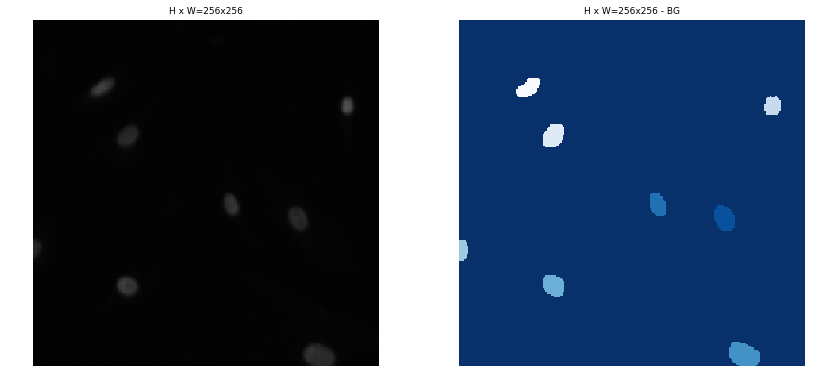

(360, 360, 3)
(360, 360, 25)


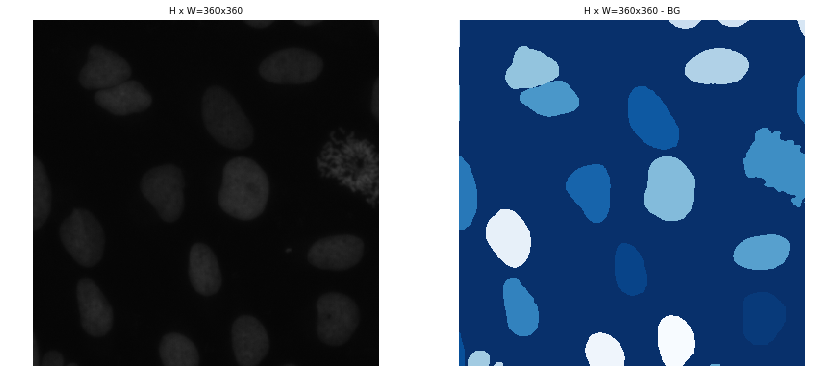

(256, 256, 3)
(256, 256, 12)


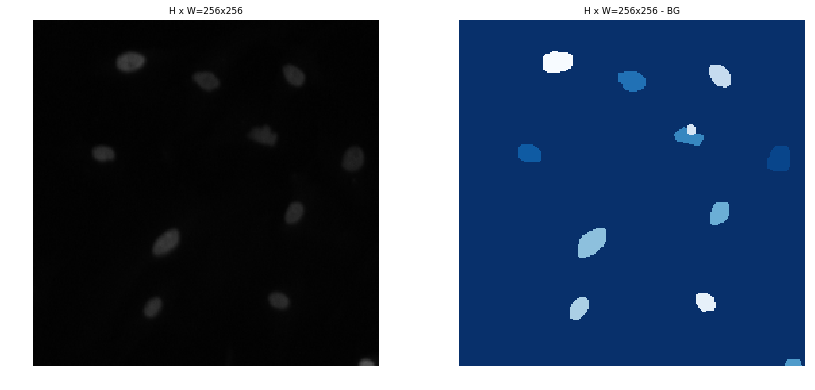

(256, 256, 3)
(256, 256, 2)


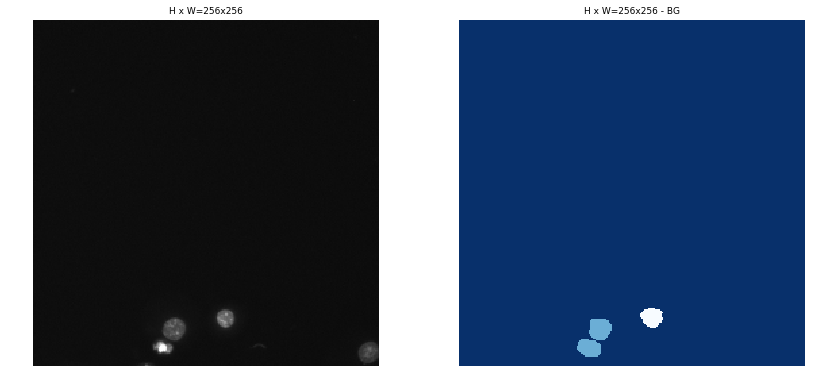

In [12]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)[:, :, 0:3]
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image.shape)
    print(mask.shape)
    display_masks(image, mask, dataset_train.class_names)

## Create Model

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [13]:
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

OSError: Unable to open file (unable to open file: name = 'E:\workspace\dl\data-science-bowl-2018\weights/mask_rcnn_coco.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Training

In [15]:
# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "nuclei20180311T1703/mask_rcnn_nuclei_0002.h5")
# model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads')

Loading weights from  E:\workspace\dl\data-science-bowl-2018\logs\nuclei20180311T1703/mask_rcnn_nuclei_0002.h5

Starting at epoch 0. LR=0.001

Checkpoint Path: E:\workspace\dl\data-science-bowl-2018\logs\nuclei20180311T1841\mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn

C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
  4/200 [..............................] - ETA: 14:53 - loss: 1.3401 - rpn_class_loss: 0.1492 - rpn_bbox_loss: 0.5969 - mrcnn_class_loss: 0.1891 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.2392

C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


200/200 [==============================] - 697s 3s/step - loss: 1.1302 - rpn_class_loss: 0.0968 - rpn_bbox_loss: 0.4869 - mrcnn_class_loss: 0.1710 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2236 - val_loss: 1.1279 - val_rpn_class_loss: 0.0792 - val_rpn_bbox_loss: 0.4492 - val_mrcnn_class_loss: 0.2123 - val_mrcnn_bbox_loss: 0.1689 - val_mrcnn_mask_loss: 0.2184
Epoch 2/2
200/200 [==============================] - 665s 3s/step - loss: 1.0669 - rpn_class_loss: 0.0845 - rpn_bbox_loss: 0.4551 - mrcnn_class_loss: 0.1645 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.2179 - val_loss: 1.0808 - val_rpn_class_loss: 0.0748 - val_rpn_bbox_loss: 0.3867 - val_mrcnn_class_loss: 0.2081 - val_mrcnn_bbox_loss: 0.1738 - val_mrcnn_mask_loss: 0.2375


In [18]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")


Starting at epoch 2. LR=0.0001

Checkpoint Path: E:\workspace\dl\data-science-bowl-2018\logs\nuclei20180311T1841\mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (

C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 3/10


ResourceExhaustedError: OOM when allocating tensor with shape[1200,256,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: mrcnn_mask_deconv/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](mrcnn_mask_deconv/stack, mrcnn_mask_deconv/kernel/read, mrcnn_mask_deconv/Reshape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: training_1/SGD/gradients/mrcnn_mask_conv1/convolution_grad/Conv2DBackpropInput/_11363 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_14822...kpropInput", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'mrcnn_mask_deconv/conv2d_transpose', defined at:
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-7928c4edfc77>", line 3, in <module>
    model_dir=MODEL_DIR)
  File "E:\workspace\dl\data-science-bowl-2018\MaskRCNN\model.py", line 1763, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "E:\workspace\dl\data-science-bowl-2018\MaskRCNN\model.py", line 1914, in build
    config.NUM_CLASSES)
  File "E:\workspace\dl\data-science-bowl-2018\MaskRCNN\model.py", line 981, in build_fpn_mask_graph
    name="mrcnn_mask_deconv")(x)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\layers\wrappers.py", line 211, in call
    y = self.layer.call(inputs, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\layers\convolutional.py", line 778, in call
    data_format=self.data_format)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 3385, in conv2d_transpose
    data_format=tf_data_format)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1257, in conv2d_transpose
    name=name)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 917, in conv2d_backprop_input
    dilations=dilations, name=name)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1200,256,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: mrcnn_mask_deconv/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](mrcnn_mask_deconv/stack, mrcnn_mask_deconv/kernel/read, mrcnn_mask_deconv/Reshape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: training_1/SGD/gradients/mrcnn_mask_conv1/convolution_grad/Conv2DBackpropInput/_11363 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_14822...kpropInput", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [17]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_head_320_ep2_200.h5")
model.keras_model.save_weights(model_path)

## Detection

In [20]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  E:\workspace\dl\data-science-bowl-2018\logs\nuclei20180311T1703\mask_rcnn_nuclei_0002.h5


original_image           shape: (512, 512, 3)         min:    0.00000  max:  109.00000
image_meta               shape: (10,)                 min:    1.00000  max:  384.00000
gt_class_id              shape: (29,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (29, 4)               min:  128.00000  max:  384.00000
gt_mask                  shape: (512, 512, 29)        min:    0.00000  max:    1.00000


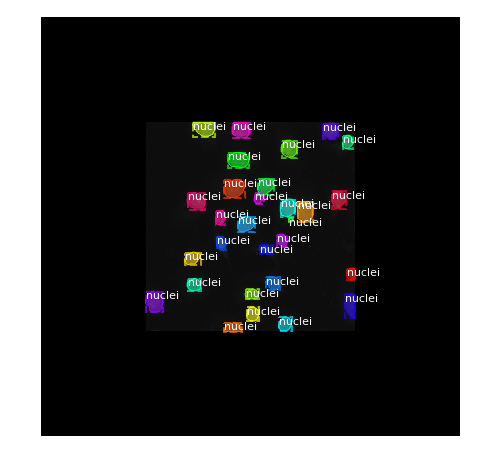

In [22]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  109.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:    5.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


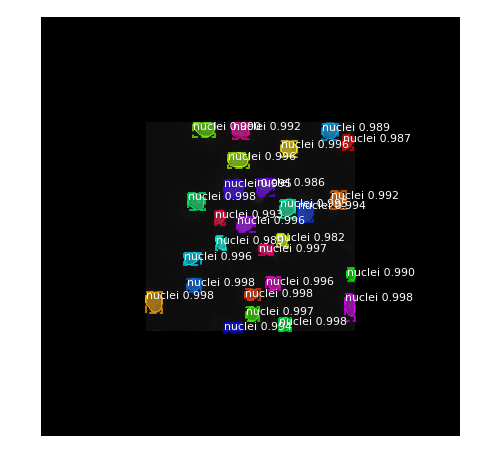

In [23]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Make Predictions

In [24]:
# Test dataset
dataset_test = NucleiDataset()
dataset_test.load_nuclei(test_path)
dataset_test.prepare()

In [25]:
print(dataset_test.image_ids[2])
print(dataset_test.image_info[0]['id'])

2
0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5


In [26]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [27]:
results = dict()
for image_id in dataset_test.image_ids[:]:
    info = dataset_test.image_info[image_id]
    image = dataset_test.load_image(image_id)
#     print(image.shape)
    result = model.detect([image], verbose=0)
#     print(result[0]['masks'].shape)
    results[info['id']] = result[0]

(256, 256, 3)
(256, 256, 6)
(256, 256)


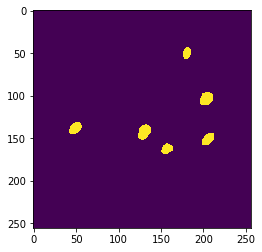

In [28]:
img_id = 0
r = results[dataset_test.image_info[img_id]['id']]
image = dataset_test.load_image(image_id)
print(image.shape)
mask = r['masks']
m = np.max(mask, axis=2)
# m = skimage.transform.resize(m, output_shape=image.shape[:2]+(1,), mode='constant', preserve_range=True)
print(mask.shape)
print(m.shape)
plt.imshow(m[:, :])
# plt.imshow(image)
# plt.imshow(mask[:, :, 4])

In [29]:
Y_hat_upsampled = []
for id_ in dataset_test.image_ids[:]:
    mask = results[dataset_test.image_info[id_]['id']]['masks']
    m = np.max(mask, axis=2)
    image = dataset_test.load_image(id_)
#     img_upscaled = skimage.transform.resize(m, (image.shape[0], image.shape[1], 1), mode='constant', preserve_range=True)
    Y_hat_upsampled.append(m)   #append upscaled image to Y_hat_upsampled
    if image.shape[:2] != m.shape:
        print(image.shape[:2])
        print(m.shape)
#     print(mask.shape)
#     print(m.shape)
print(Y_hat_upsampled[0].shape)
len(Y_hat_upsampled)

(256, 256)


65

In [30]:
# Apply Run-Length Encoding on our Y_hat_upscaled
new_test_ids = []
rles = []
for id_ in dataset_test.image_ids:
    rle = list(prob_to_rles(Y_hat_upsampled[id_]))
    rles.extend(rle)
    new_test_ids.extend([dataset_test.image_info[id_]['id']] * len(rle))
len(new_test_ids)  #note that for each test_image, we can have multiple entries of encoded pixels

2409

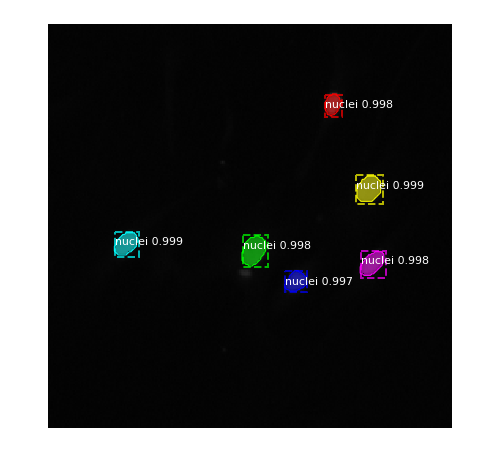

In [31]:
r = results[dataset_test.image_info[0]['id']]
original_image = dataset_test.load_image(0)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

[0 0 0 0 0 0]


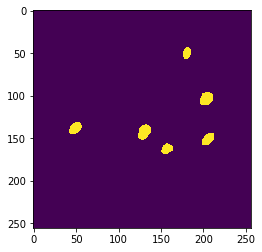

In [32]:
id = 0
r = results[dataset_test.image_info[id]['id']]
plt.imshow(Y_hat_upsampled[id][:, :])
print(r['masks'][0][0])

In [33]:
# Create submission DataFrame
sub = pd.DataFrame()

# img_ids = []
# rois = []
# for img_id, data in results.items():
#     img_ids.append(img_id)
#     r = results[img_id][0]['rois']
#     rois.append(' '.join(str(y) for y in r.flatten()))

# sub['ImageId'] = img_ids
# sub['EncodedPixels'] = rois

sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

sub.head()

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45105 7 45359 11 45614 12 45870 13 46125 13 46...
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50280 7 50534 10 50789 12 51043 14 51299 14 51...
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10893 4 11147 7 11401 10 11656 11 11911 12 121...
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31633 6 31886 10 32139 14 32394 15 32649 17 32...
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50842 5 51096 7 51351 9 51605 11 51860 12 5211...


In [34]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
print('Submission output to: sub-{}.csv'.format(timestamp))
sub.to_csv(OUTPUT_DIR + "\sub-{}.csv".format(timestamp), index=False)

Submission output to: sub-20180311-1814.csv


## Evaluation

In [ ]:
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))